# General data reader for AQUA 
## Time averaging

Input data may not be available at the desired time frequency. It is possible to perform time averaging at a given frequency (currently daily and monthly are implemented) using the `timmean()` method of the reader. It would in theory be possible also to specify averaging already when instantiating the reader, but this may not be the most efficient choice.

In [1]:
from aqua import Reader

Here we demonstrate the functionality for sample IFS data which at the same time are also regridded to a desired 1°x1° grid. 

In [2]:
reader = Reader(model="IFS", exp="tco2559-ng5", source="ICMGG_atm2d", regrid="r100", fix=False)
data = reader.retrieve()
data

<xarray.Dataset>
Dimensions:  (time: 8329, value: 26306560, level: 6)
Coordinates:
    lat      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
  * level    (level) int64 0 1 2 3 4 5
    lon      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2020-01-20 2020-01-20T01:00:00 ... 2021-01-01
Dimensions without coordinates: value
Data variables: (12/82)
    100si    (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    100u     (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    100v     (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    10u      (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    10v      (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    2d       (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    ...       ...
    uvb      (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    vike     (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    vipie    (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    vipile   (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    vithe    (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    z        (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
Attributes:
    edition:            1
    centre:             ecmf
    centreDescription:  European Centre for Medium-Range Weather Forecasts
    subCentre:          0
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.IF...

These data are still at the original (hourly) frequency. Let's time average just the surface temperatures (the original data in this case). We specify the regridding frequency with the `freq` keyword. :

In [3]:
daily = reader.timmean(data['2t'], freq = 'daily')
daily

<xarray.DataArray '2t' (time: 348, value: 26306560)>
dask.array<stack, shape=(348, 26306560), dtype=float64, chunksize=(1, 26306560), chunktype=numpy.ndarray>
Coordinates:
    lat      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
    lon      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2020-01-20 2020-01-21 ... 2021-01-01
Dimensions without coordinates: value
Attributes: (12/16)
    paramId:                    167
    dataType:                   fc
    numberOfPoints:             26306560
    typeOfLevel:                surface
    stepUnits:                  1
    stepType:                   instant
    ...                         ...
    cfVarName:                  t2m
    missingValue:               3.4028234663852886e+38
    totalNumber:                0
    NV:                         0
    gridDefinitionDescription:  Gaussian Latitude/Longitude Grid
    history:                    2023-11-30 16:32:54 resampled to frequency 1D...

Data have now been averaged at the daily timescale. We can proceed and regrid them

In [4]:
tas = reader.regrid(daily[2,:])
tas

<xarray.DataArray '2t' (lat: 180, lon: 360)>
dask.array<reshape, shape=(180, 360), dtype=float64, chunksize=(180, 360), chunktype=numpy.ndarray>
Coordinates:
    time     datetime64[ns] 2020-01-22
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
Attributes: (12/17)
    paramId:                    167
    dataType:                   fc
    numberOfPoints:             26306560
    typeOfLevel:                surface
    stepUnits:                  1
    stepType:                   instant
    ...                         ...
    missingValue:               3.4028234663852886e+38
    totalNumber:                0
    NV:                         0
    gridDefinitionDescription:  Gaussian Latitude/Longitude Grid
    history:                    2023-11-30 16:32:54 resampled to frequency 1D...
    regridded:                  1

And we call the plot. This might takes a bit of time, since the files need to be loaded. Dask should be reasonably efficient calling only the frames that we need to create the time averaging. 

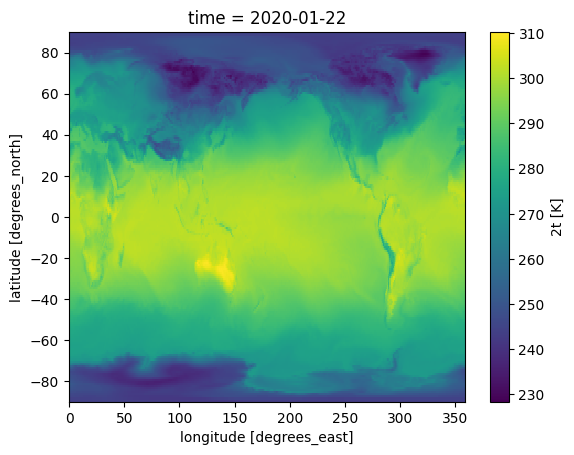

In [5]:
tas.plot()